In [1]:

!pip install gdown timm

import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import timm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/content/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)

# Check if the file is indeed a ZIP file
zip_path = '/content/shared_file.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/content')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=4d3ebebe-6214-44b8-8fcb-41070f45c039
To: /content/shared_file.zip
100%|██████████| 1.46G/1.46G [00:57<00:00, 25.4MB/s]


ZIP file opened successfully.
Extraction complete.
Using device: cuda


In [10]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img, label_tensor

# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load data
data_dirs = {
    'T4_Ptrain': ["l0", "l1", "l2"],
    'T4_Ptest': ["l0", "l1", "l2"]
}
data_root = "/content/T4_Pdata"

# Function to load dataset
def load_data(phase, data_dirs, data_root):
    data = []
    for label, folder in enumerate(data_dirs[phase]):
        folder_path = os.path.join(data_root, phase, folder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            data.append((image_path, label))
    return data

train_data = load_data('T4_Ptrain', data_dirs, data_root)
test_data = load_data('T4_Ptest', data_dirs, data_root)

# Split train data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=[label for _, label in train_data])

# Create datasets
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_val_transform)
test_dataset = CustomDataset(test_data, transform=test_val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = timm.create_model("deit_tiny_patch16_224", pretrained=True)

# Modify the final layer
num_classes = len(data_dirs['T4_Ptrain'])
model.head = nn.Linear(model.head.in_features, num_classes)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)

# Define loss function with class weights
class_counts = np.bincount([label for _, label in train_data])
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [11]:
# Train the model
num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({'Loss': train_loss / total, 'Accuracy': 100 * correct / total})

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    scheduler.step(val_loss)


Epoch 1/100, Train Loss: 0.8540, Train Accuracy: 54.43%, Val Loss: 0.7159, Val Accuracy: 62.74%


Epoch 2/100, Train Loss: 0.6976, Train Accuracy: 64.99%, Val Loss: 0.6407, Val Accuracy: 73.25%


Epoch 3/100, Train Loss: 0.6428, Train Accuracy: 67.78%, Val Loss: 0.6510, Val Accuracy: 73.09%


Epoch 4/100, Train Loss: 0.5692, Train Accuracy: 70.89%, Val Loss: 0.5491, Val Accuracy: 72.29%


Epoch 5/100, Train Loss: 0.5470, Train Accuracy: 73.48%, Val Loss: 0.6575, Val Accuracy: 73.57%


Epoch 6/100, Train Loss: 0.4762, Train Accuracy: 77.11%, Val Loss: 0.5608, Val Accuracy: 77.23%


Epoch 7/100, Train Loss: 0.4420, Train Accuracy: 78.83%, Val Loss: 0.5304, Val Accuracy: 78.82%


Epoch 8/100, Train Loss: 0.3807, Train Accuracy: 81.46%, Val Loss: 0.5567, Val Accuracy: 78.82%


Epoch 9/100, Train Loss: 0.3616, Train Accuracy: 82.54%, Val Loss: 0.5198, Val Accuracy: 77.23%


Epoch 10/100, Train Loss: 0.3060, Train Accuracy: 85.49%, Val Loss: 0.5250, Val Accuracy: 78.50%


Epoch 11/100, Train Loss: 0.3074, Train Accuracy: 86.28%, Val Loss: 0.5368, Val Accuracy: 81.53%


Epoch 12/100, Train Loss: 0.2671, Train Accuracy: 88.24%, Val Loss: 0.4740, Val Accuracy: 81.37%


Epoch 13/100, Train Loss: 0.2445, Train Accuracy: 89.11%, Val Loss: 0.5700, Val Accuracy: 82.96%


Epoch 14/100, Train Loss: 0.2359, Train Accuracy: 89.07%, Val Loss: 0.4889, Val Accuracy: 83.92%


Epoch 15/100, Train Loss: 0.2560, Train Accuracy: 88.64%, Val Loss: 0.5689, Val Accuracy: 82.17%


Epoch 16/100, Train Loss: 0.2138, Train Accuracy: 90.39%, Val Loss: 0.4706, Val Accuracy: 85.19%


Epoch 17/100, Train Loss: 0.1754, Train Accuracy: 92.30%, Val Loss: 0.5641, Val Accuracy: 85.03%


Epoch 18/100, Train Loss: 0.1669, Train Accuracy: 92.46%, Val Loss: 0.6475, Val Accuracy: 82.17%


Epoch 19/100, Train Loss: 0.1763, Train Accuracy: 92.03%, Val Loss: 0.4784, Val Accuracy: 84.24%


Epoch 20/100, Train Loss: 0.1529, Train Accuracy: 93.22%, Val Loss: 0.4974, Val Accuracy: 86.62%


Epoch 21/100, Train Loss: 0.1374, Train Accuracy: 94.14%, Val Loss: 0.4826, Val Accuracy: 86.78%


Epoch 22/100, Train Loss: 0.1199, Train Accuracy: 94.38%, Val Loss: 0.5726, Val Accuracy: 85.19%


Epoch 23/100, Train Loss: 0.1663, Train Accuracy: 92.94%, Val Loss: 0.5261, Val Accuracy: 82.80%


Epoch 24/100, Train Loss: 0.1239, Train Accuracy: 94.86%, Val Loss: 0.5425, Val Accuracy: 87.10%


Epoch 25/100, Train Loss: 0.1025, Train Accuracy: 95.45%, Val Loss: 0.5579, Val Accuracy: 83.60%


Epoch 26/100, Train Loss: 0.0870, Train Accuracy: 96.45%, Val Loss: 0.5429, Val Accuracy: 87.26%


Epoch 27/100, Train Loss: 0.0988, Train Accuracy: 95.45%, Val Loss: 0.5826, Val Accuracy: 84.39%


Epoch 28/100, Train Loss: 0.0540, Train Accuracy: 97.85%, Val Loss: 0.5262, Val Accuracy: 87.74%


Epoch 29/100, Train Loss: 0.0328, Train Accuracy: 98.76%, Val Loss: 0.5337, Val Accuracy: 88.06%


Epoch 30/100, Train Loss: 0.0281, Train Accuracy: 98.80%, Val Loss: 0.5331, Val Accuracy: 88.06%


Epoch 31/100, Train Loss: 0.0252, Train Accuracy: 99.04%, Val Loss: 0.5372, Val Accuracy: 87.90%


Epoch 32/100, Train Loss: 0.0271, Train Accuracy: 99.08%, Val Loss: 0.5394, Val Accuracy: 87.90%


Epoch 33/100, Train Loss: 0.0244, Train Accuracy: 98.88%, Val Loss: 0.5533, Val Accuracy: 88.38%


Epoch 34/100, Train Loss: 0.0196, Train Accuracy: 99.44%, Val Loss: 0.5514, Val Accuracy: 88.38%


Epoch 35/100, Train Loss: 0.0173, Train Accuracy: 99.20%, Val Loss: 0.5766, Val Accuracy: 88.22%


Epoch 36/100, Train Loss: 0.0171, Train Accuracy: 99.28%, Val Loss: 0.6069, Val Accuracy: 87.90%


Epoch 37/100, Train Loss: 0.0193, Train Accuracy: 99.24%, Val Loss: 0.5805, Val Accuracy: 87.74%


Epoch 38/100, Train Loss: 0.0192, Train Accuracy: 99.16%, Val Loss: 0.5585, Val Accuracy: 88.06%


Epoch 39/100, Train Loss: 0.0167, Train Accuracy: 99.28%, Val Loss: 0.5619, Val Accuracy: 88.22%


Epoch 40/100, Train Loss: 0.0176, Train Accuracy: 99.28%, Val Loss: 0.5674, Val Accuracy: 88.22%


Epoch 41/100, Train Loss: 0.0128, Train Accuracy: 99.60%, Val Loss: 0.5711, Val Accuracy: 88.38%


Epoch 42/100, Train Loss: 0.0133, Train Accuracy: 99.56%, Val Loss: 0.5804, Val Accuracy: 88.38%


Epoch 43/100, Train Loss: 0.0134, Train Accuracy: 99.48%, Val Loss: 0.5809, Val Accuracy: 88.38%


Epoch 44/100, Train Loss: 0.0146, Train Accuracy: 99.36%, Val Loss: 0.5828, Val Accuracy: 88.22%


Epoch 45/100, Train Loss: 0.0139, Train Accuracy: 99.56%, Val Loss: 0.5811, Val Accuracy: 88.22%


Epoch 46/100, Train Loss: 0.0153, Train Accuracy: 99.32%, Val Loss: 0.5816, Val Accuracy: 88.06%


Epoch 47/100, Train Loss: 0.0130, Train Accuracy: 99.52%, Val Loss: 0.5822, Val Accuracy: 88.06%


Epoch 48/100, Train Loss: 0.0116, Train Accuracy: 99.68%, Val Loss: 0.5890, Val Accuracy: 88.38%


Epoch 49/100, Train Loss: 0.0116, Train Accuracy: 99.64%, Val Loss: 0.5854, Val Accuracy: 88.22%


Epoch 50/100, Train Loss: 0.0138, Train Accuracy: 99.56%, Val Loss: 0.5921, Val Accuracy: 88.38%


Epoch 51/100, Train Loss: 0.0125, Train Accuracy: 99.72%, Val Loss: 0.5907, Val Accuracy: 88.38%


Epoch 52/100, Train Loss: 0.0140, Train Accuracy: 99.36%, Val Loss: 0.5975, Val Accuracy: 88.22%


Epoch 53/100, Train Loss: 0.0113, Train Accuracy: 99.68%, Val Loss: 0.5992, Val Accuracy: 88.22%


Epoch 54/100, Train Loss: 0.0130, Train Accuracy: 99.52%, Val Loss: 0.5989, Val Accuracy: 88.38%


Epoch 55/100, Train Loss: 0.0135, Train Accuracy: 99.52%, Val Loss: 0.5975, Val Accuracy: 88.38%


Epoch 56/100, Train Loss: 0.0112, Train Accuracy: 99.72%, Val Loss: 0.5973, Val Accuracy: 88.38%


Epoch 57/100, Train Loss: 0.0115, Train Accuracy: 99.52%, Val Loss: 0.5976, Val Accuracy: 88.38%


Epoch 58/100, Train Loss: 0.0130, Train Accuracy: 99.56%, Val Loss: 0.5991, Val Accuracy: 88.54%


Epoch 59/100, Train Loss: 0.0139, Train Accuracy: 99.64%, Val Loss: 0.6000, Val Accuracy: 88.38%


Epoch 60/100, Train Loss: 0.0118, Train Accuracy: 99.60%, Val Loss: 0.5939, Val Accuracy: 88.69%


Epoch 61/100, Train Loss: 0.0114, Train Accuracy: 99.52%, Val Loss: 0.5993, Val Accuracy: 88.69%


Epoch 62/100, Train Loss: 0.0115, Train Accuracy: 99.64%, Val Loss: 0.6008, Val Accuracy: 88.54%


Epoch 63/100, Train Loss: 0.0116, Train Accuracy: 99.52%, Val Loss: 0.6042, Val Accuracy: 88.85%


Epoch 64/100, Train Loss: 0.0112, Train Accuracy: 99.60%, Val Loss: 0.6024, Val Accuracy: 88.85%


Epoch 65/100, Train Loss: 0.0110, Train Accuracy: 99.60%, Val Loss: 0.6023, Val Accuracy: 88.69%


Epoch 66/100, Train Loss: 0.0121, Train Accuracy: 99.44%, Val Loss: 0.6053, Val Accuracy: 88.69%


Epoch 67/100, Train Loss: 0.0122, Train Accuracy: 99.60%, Val Loss: 0.5973, Val Accuracy: 88.54%


Epoch 68/100, Train Loss: 0.0090, Train Accuracy: 99.72%, Val Loss: 0.5948, Val Accuracy: 88.54%


Epoch 69/100, Train Loss: 0.0112, Train Accuracy: 99.52%, Val Loss: 0.6068, Val Accuracy: 88.69%


Epoch 70/100, Train Loss: 0.0094, Train Accuracy: 99.76%, Val Loss: 0.6156, Val Accuracy: 88.69%


Epoch 71/100, Train Loss: 0.0120, Train Accuracy: 99.64%, Val Loss: 0.6080, Val Accuracy: 88.54%


Epoch 72/100, Train Loss: 0.0114, Train Accuracy: 99.72%, Val Loss: 0.6027, Val Accuracy: 88.38%


Epoch 73/100, Train Loss: 0.0092, Train Accuracy: 99.60%, Val Loss: 0.6045, Val Accuracy: 88.54%


Epoch 74/100, Train Loss: 0.0087, Train Accuracy: 99.76%, Val Loss: 0.6094, Val Accuracy: 88.69%


Epoch 75/100, Train Loss: 0.0100, Train Accuracy: 99.72%, Val Loss: 0.6068, Val Accuracy: 88.85%


Epoch 76/100, Train Loss: 0.0088, Train Accuracy: 99.72%, Val Loss: 0.6108, Val Accuracy: 88.54%


Epoch 77/100, Train Loss: 0.0109, Train Accuracy: 99.64%, Val Loss: 0.6089, Val Accuracy: 88.38%


Epoch 78/100, Train Loss: 0.0123, Train Accuracy: 99.52%, Val Loss: 0.6141, Val Accuracy: 88.69%


Epoch 79/100, Train Loss: 0.0101, Train Accuracy: 99.68%, Val Loss: 0.6190, Val Accuracy: 88.85%


Epoch 80/100, Train Loss: 0.0077, Train Accuracy: 99.88%, Val Loss: 0.6179, Val Accuracy: 88.85%


Epoch 81/100, Train Loss: 0.0089, Train Accuracy: 99.72%, Val Loss: 0.6125, Val Accuracy: 88.69%


Epoch 82/100, Train Loss: 0.0089, Train Accuracy: 99.72%, Val Loss: 0.6160, Val Accuracy: 89.01%


Epoch 83/100, Train Loss: 0.0090, Train Accuracy: 99.80%, Val Loss: 0.6124, Val Accuracy: 88.54%


Epoch 84/100, Train Loss: 0.0088, Train Accuracy: 99.76%, Val Loss: 0.6128, Val Accuracy: 88.69%


Epoch 85/100, Train Loss: 0.0076, Train Accuracy: 99.76%, Val Loss: 0.6188, Val Accuracy: 88.38%


Epoch 86/100, Train Loss: 0.0072, Train Accuracy: 99.84%, Val Loss: 0.6168, Val Accuracy: 88.54%


Epoch 87/100, Train Loss: 0.0094, Train Accuracy: 99.60%, Val Loss: 0.6322, Val Accuracy: 88.69%


Epoch 88/100, Train Loss: 0.0074, Train Accuracy: 99.80%, Val Loss: 0.6264, Val Accuracy: 88.54%


Epoch 89/100, Train Loss: 0.0075, Train Accuracy: 99.76%, Val Loss: 0.6228, Val Accuracy: 88.38%


Epoch 90/100, Train Loss: 0.0081, Train Accuracy: 99.84%, Val Loss: 0.6164, Val Accuracy: 88.54%


Epoch 91/100, Train Loss: 0.0082, Train Accuracy: 99.64%, Val Loss: 0.6264, Val Accuracy: 88.69%


Epoch 92/100, Train Loss: 0.0082, Train Accuracy: 99.64%, Val Loss: 0.6332, Val Accuracy: 88.54%


Epoch 93/100, Train Loss: 0.0104, Train Accuracy: 99.68%, Val Loss: 0.6285, Val Accuracy: 88.69%


Epoch 94/100, Train Loss: 0.0081, Train Accuracy: 99.72%, Val Loss: 0.6266, Val Accuracy: 89.01%


Epoch 95/100, Train Loss: 0.0098, Train Accuracy: 99.68%, Val Loss: 0.6286, Val Accuracy: 88.69%


Epoch 96/100, Train Loss: 0.0126, Train Accuracy: 99.52%, Val Loss: 0.6366, Val Accuracy: 88.54%


Epoch 97/100, Train Loss: 0.0074, Train Accuracy: 99.92%, Val Loss: 0.6284, Val Accuracy: 88.69%


Epoch 98/100, Train Loss: 0.0089, Train Accuracy: 99.68%, Val Loss: 0.6222, Val Accuracy: 88.69%


Epoch 99/100, Train Loss: 0.0104, Train Accuracy: 99.56%, Val Loss: 0.6266, Val Accuracy: 88.54%


Epoch 100/100, Train Loss: 0.0088, Train Accuracy: 99.76%, Val Loss: 0.6224, Val Accuracy: 88.69%


In [15]:
# Save the trained model
torch.save(model.state_dict(), '/content/deit_tiny_model.pth')

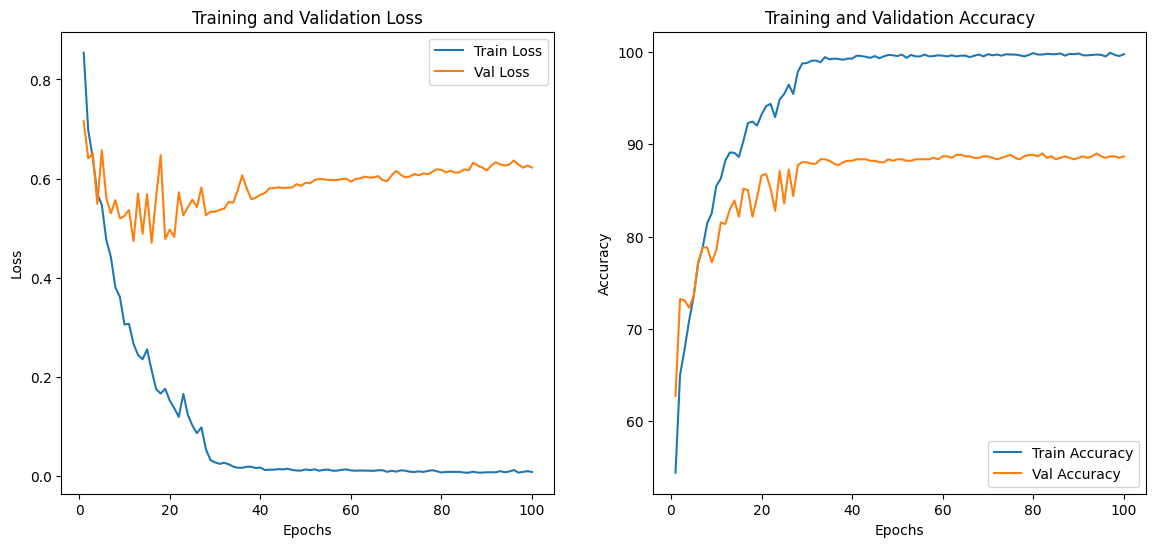

In [12]:

# Plotting training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [13]:

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)

# Generate classification report
true_labels = torch.tensor(true_labels).cpu().numpy()
predictions = torch.tensor(predictions).cpu().numpy()
report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


Test Accuracy: 91.87%
              precision    recall  f1-score   support

     Class 0       0.91      0.82      0.86       118
     Class 1       0.95      0.94      0.94       187
     Class 2       0.91      0.94      0.92       322

    accuracy                           0.92       627
   macro avg       0.92      0.90      0.91       627
weighted avg       0.92      0.92      0.92       627



In [14]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import numpy as np

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)]))

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Calculate per-class metrics
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * precision * recall / (precision + recall)

# Calculate macro-averaged metrics
macro_recall = np.mean(recall)
macro_precision = np.mean(precision)
macro_f1_score = np.mean(f1_score)
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
custom_balanced_accuracy = np.mean((recall + specificity) / 2)

# Print class-wise metrics
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Specificity: {specificity[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BAC): {balanced_accuracy:.3f}")
print(f"Custom Balanced Accuracy (BCC): {custom_balanced_accuracy:.3f}")


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.82      0.86       118
     Class 1       0.95      0.94      0.94       187
     Class 2       0.91      0.94      0.92       322

    accuracy                           0.92       627
   macro avg       0.92      0.90      0.91       627
weighted avg       0.92      0.92      0.92       627

Confusion Matrix:
[[ 97   0  21]
 [  1 176  10]
 [  9  10 303]]

Class-wise Metrics:
Class 0:
  TP: 97
  TN: 499
  FP: 10
  FN: 21
  Recall: 0.822
  Specificity: 0.980
  Precision: 0.907
  F1-score: 0.862
Class 1:
  TP: 176
  TN: 430
  FP: 10
  FN: 11
  Recall: 0.941
  Specificity: 0.977
  Precision: 0.946
  F1-score: 0.944
Class 2:
  TP: 303
  TN: 274
  FP: 31
  FN: 19
  Recall: 0.941
  Specificity: 0.898
  Precision: 0.907
  F1-score: 0.924

Macro-averaged Metrics:
Macro Recall: 0.901
Macro Precision: 0.920
Macro F1-score: 0.910
Accuracy (ACC): 0.919
Balanced Accuracy (BAC): 0.901
Custom